### Fingerprint

A técnica de Fingerprint envolve a criação de um banco de dados contendo amostras de informações, como potência do sinal, time advance e outros parâmetros que caracterizam uma determinada região. O conceito subjacente a esse algoritmo é utilizar esse banco de dados como um espaço de referência, no qual é possível comparar os sinais coletados em uma localização desconhecida com as informações armazenadas na base de dados. Isso permite estimar qual ponto da base de dados é mais similar à posição atual do objeto de interesse.

###  Solução:

O algoritmo de busca Fingerprint utiliza o cálculo da distância euclidiana, considerando as perdas em espaço livre das estações rádio base como características (features) e é inspirado no conceito de Fingerprint. Este algoritmo, baseado em machine learning, utiliza uma abordagem de regressão linear. Ele emprega as perdas em espaço livre das estações rádio base como entradas e tem como saída a estimativa da latitude e longitude do objeto de interesse.

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from branca.element import Figure
import folium

In [160]:
# Carregando os dados
df = pd.read_csv("../../project_files/03_processed_files/meds_train_alunos.csv")


In [161]:
df.head()

,Unnamed: 0.1,Unnamed: 0,id_ponto,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,delay_1,delay_2,delay_3,num_lat_bts,num_long_bts,flag_indoor
0,0,0,6604,-103.705000,-110.425000,-107.381667,-110.330000,-108.345000,-106.590000,-107.153333,-102.120000,-115.00,5.0,3.0,2.0,-8.055786,-34.951505,True
1,1,1,5515,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-88.470000,-94.024286,-108.12,5.0,3.0,2.0,-8.055784,-34.951608,True
2,2,2,5049,-102.610000,-115.000000,-101.380000,-115.000000,-104.295000,-97.360000,-96.980000,-99.572500,-115.00,5.0,3.0,2.0,-8.055506,-34.951693,True
3,3,3,8737,-89.140000,-97.251429,-86.642857,-96.036667,-96.592500,-92.460000,-86.813333,-102.688000,-87.27,4.0,7.0,2.0,-8.050390,-34.959630,False
4,4,4,1203,-109.088333,-107.200000,-107.010000,-108.430000,-104.845714,-101.435714,-103.065000,-102.110000,-115.00,5.0,3.0,2.0,-8.055380,-34.951736,True


In [162]:
X = df[['rssi_1_1', 'rssi_1_2', 'rssi_1_3', 'rssi_2_1', 'rssi_2_2', 'rssi_2_3', 'rssi_3_1', 'rssi_3_2', 'rssi_3_3']]
y = df[['num_lat_bts', 'num_long_bts']]

In [163]:
# Divisão dos dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Distância Euclidiana

In [164]:
import math

def vector_subtract(v,w):
    # Subtrai dois vetores e retorna o resultado.
    return [v_i - w_i for v_i, w_i in zip(v,w)]

def dot(v,w):
    # Calcula o produto escalar de dois vetores.
    return sum(v_i * w_i for v_i, w_i in zip(v,w))

def sum_of_squares(v):
    # Calcula a soma dos quadrados dos componentes de um vetor.
    return dot(v,v)

def magnitude(v):
    # Calcula a magnitude (ou comprimento) de um vetor.
    return math.sqrt(sum_of_squares(v))

def distance(v,w):
    # Calcula a distância euclidiana entre dois vetores.
    return magnitude(vector_subtract(v,w))

In [165]:
def fingerprint(v,df):
  df['distance'] = [distance(list(w),list(v)) for w in df.values.tolist()]
  df = df.sort_values(by='distance',ascending=True)
  df = df.reset_index()
  return df.loc[0, ['num_lat_bts','num_long_bts']]

In [166]:
v = [106,	122,	114,	123,	130,	111]
df_ = X_train.copy()
df_['num_lat_bts'] = y_train['num_lat_bts']
df_['num_long_bts'] = y_train['num_long_bts']
fingerprint(v,df_)

num_lat_bts     -8.05420
num_long_bts   -34.94651
Name: 0, dtype: float64

In [167]:
# Previsoes fingerprint
Y_pred = [list(fingerprint(v,df_)) for _,v in X_test.iterrows()]


In [168]:
Y_pred
df2 = y_test.copy()

df2['lat_pred'] = [lat for lat,_ in Y_pred]
df2['lon_pred'] = [lon for _,lon in Y_pred]

In [169]:
df2['lat_diff'] = df2['num_lat_bts'] - df2['lat_pred']
df2['lon_diff'] = df2['num_long_bts'] - df2['lon_pred']

In [170]:
df2.head()


,num_lat_bts,num_long_bts,lat_pred,lon_pred,lat_diff,lon_diff
5997,-8.048630,-34.952930,-8.048440,-34.952430,-0.00019,-0.00050
4882,-8.055506,-34.951693,-8.055506,-34.951693,0.00000,0.00000
2955,-8.055786,-34.951505,-8.055786,-34.951505,0.00000,0.00000
2303,-8.047130,-34.950590,-8.046910,-34.950600,-0.00022,0.00001
496,-8.051920,-34.947800,-8.051910,-34.947850,-0.00001,0.00005


In [171]:
df2['lat_diff'] = df2['num_lat_bts'] - df2['lat_pred']
df2['lon_diff'] = df2['num_long_bts'] - df2['lon_pred']
     

In [172]:
df2.head()


,num_lat_bts,num_long_bts,lat_pred,lon_pred,lat_diff,lon_diff
5997,-8.048630,-34.952930,-8.048440,-34.952430,-0.00019,-0.00050
4882,-8.055506,-34.951693,-8.055506,-34.951693,0.00000,0.00000
2955,-8.055786,-34.951505,-8.055786,-34.951505,0.00000,0.00000
2303,-8.047130,-34.950590,-8.046910,-34.950600,-0.00022,0.00001
496,-8.051920,-34.947800,-8.051910,-34.947850,-0.00001,0.00005


In [173]:

df2['lat_diff_metros'] = df2['lat_diff'] * 30.87 * 1000
df2['lon_diff_metros'] = df2['lon_diff'] * 30.87 * 1000

In [174]:
import math
df2['diff_metros'] = [math.sqrt(lat_diff**2+lon_diff**2) for lat_diff,lon_diff in zip(df2['lat_diff_metros'],df2['lon_diff_metros'])]
     

In [175]:
df2['diff_metros'].describe()


count    1353.000000
mean        7.076586
std        24.835608
min         0.000000
25%         0.000000
50%         0.000000
75%         2.247370
max       414.044501
Name: diff_metros, dtype: float64

<Axes: >

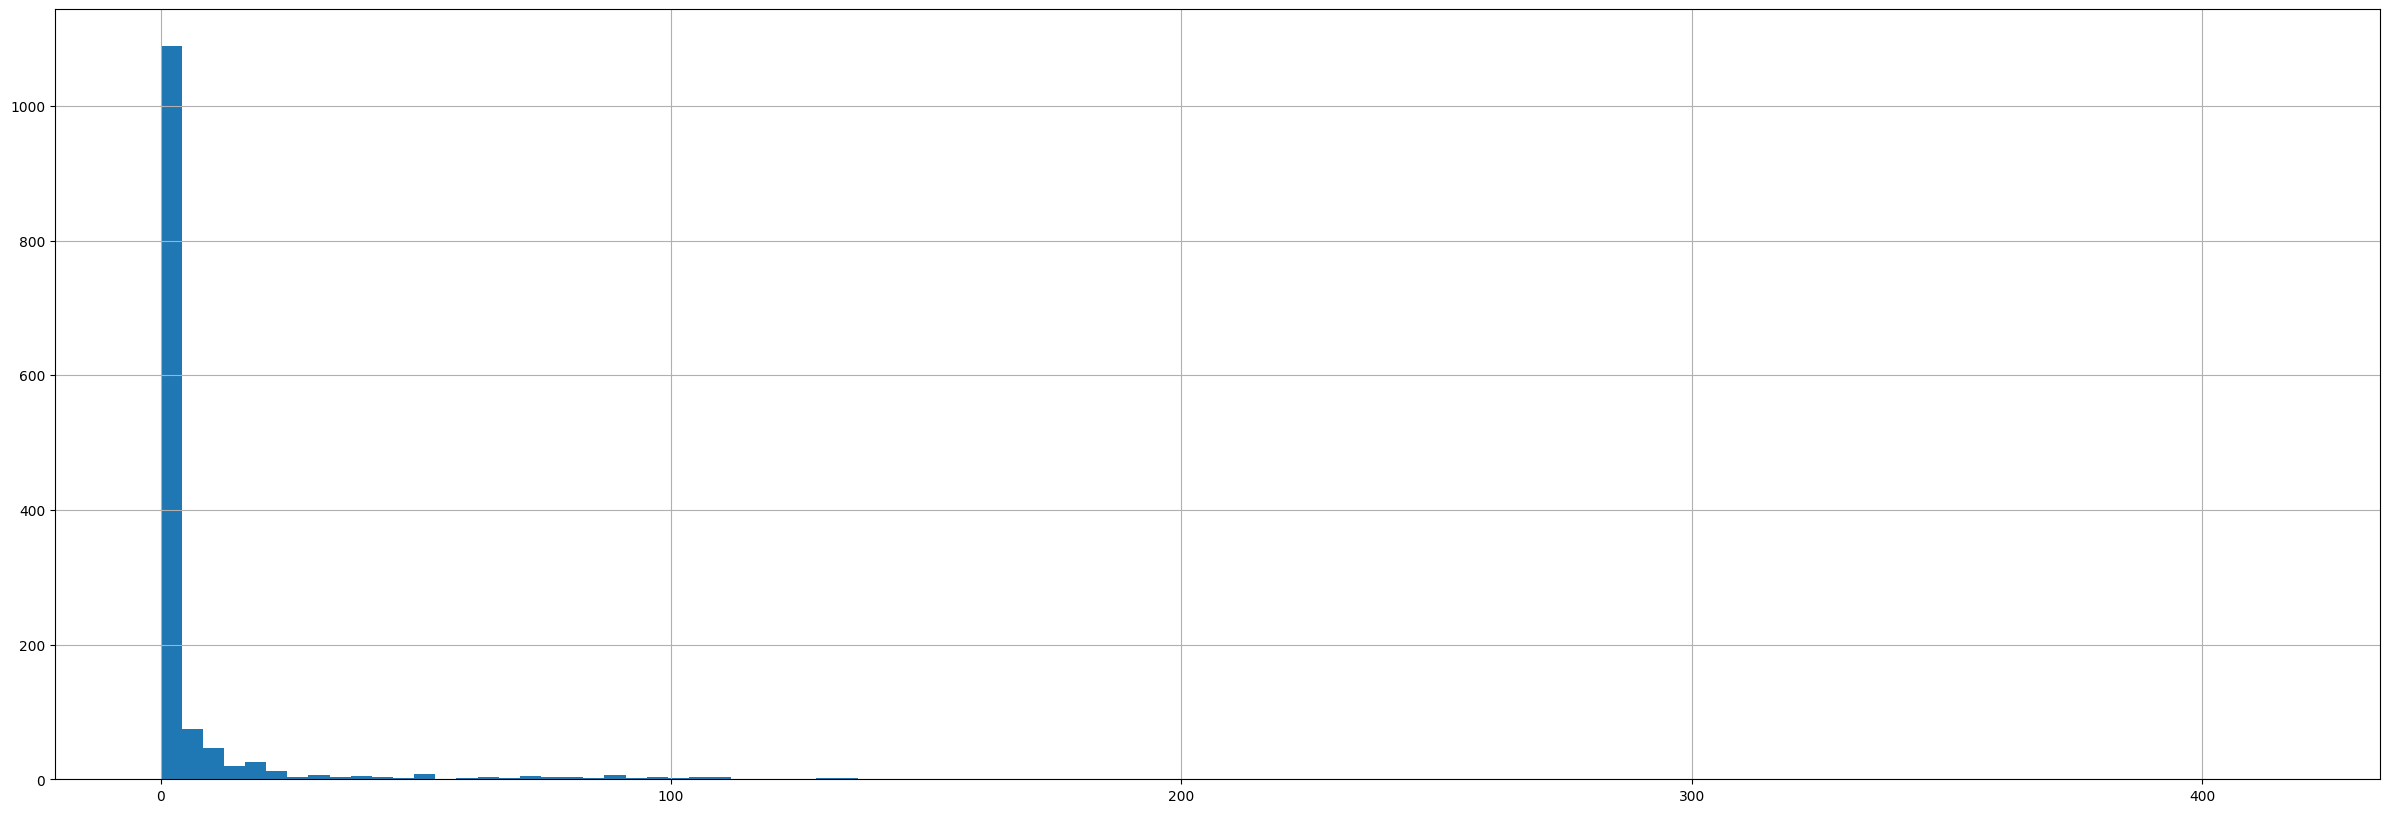

In [176]:
df2['diff_metros'].hist(bins=100,figsize=(30,10))


### Mapa de comparação: posições preditas vs. posições reais


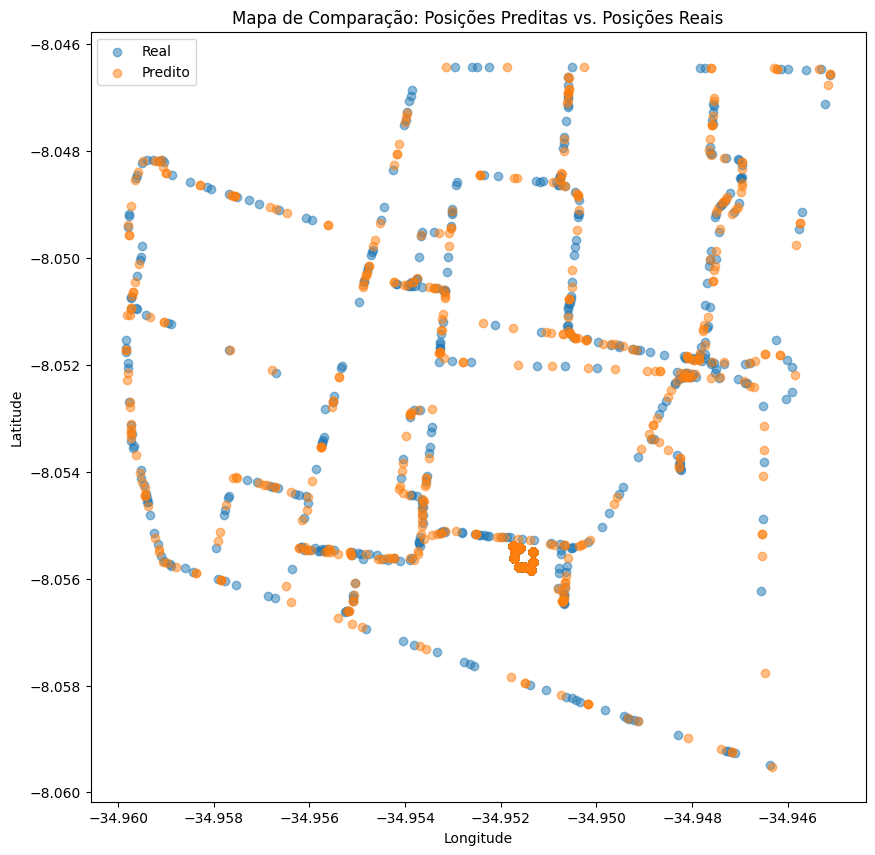

In [177]:
import numpy as np
Y_pred_array = np.array(Y_pred)
plt.figure(figsize=(10, 10))
plt.scatter(y_test['num_long_bts'], y_test['num_lat_bts'], label='Real', alpha=0.5)
plt.scatter(Y_pred_array[:, 1], Y_pred_array[:, 0], label='Predito', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mapa de Comparação: Posições Preditas vs. Posições Reais')
plt.legend()
plt.show()




In [178]:
os = folium.Map(location=[-8.0556479,-34.9532624], zoom_start=15)

for _, row in df2[['num_lat_bts','num_long_bts']].iterrows():
    folium.CircleMarker(location=[row["num_lat_bts"], row["num_long_bts"]],radius=5, color = 'blue',fill_opacity=0.7).add_to(os)

for _, row in df2[['lat_pred','lon_pred']].iterrows():
    folium.CircleMarker(location=[row["lat_pred"], row["lon_pred"]],radius=5, color = 'orange',fill_opacity=0.3).add_to(os)
os

### Avaliação do Modelo

In [179]:
# Avaliação do modelo
mse = mean_squared_error(y_test, Y_pred_array)
mae = mean_absolute_error(y_test, Y_pred_array)

In [180]:

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 3.4966407982268916e-07
Mean Absolute Error (MAE): 0.0001458019216556416


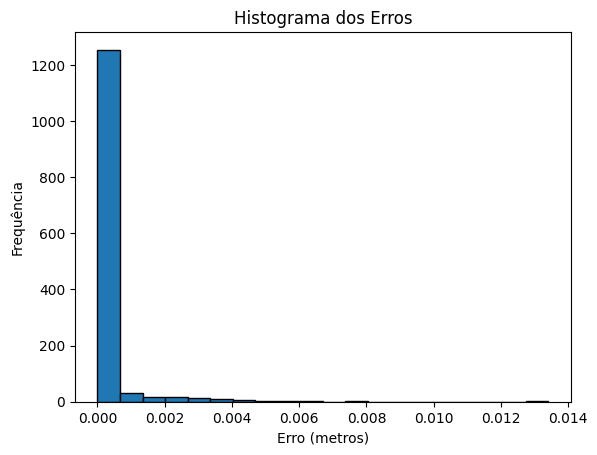

In [181]:
# Histograma e Box-Plot dos Erros
errors = np.sqrt(np.sum((Y_pred_array - y_test) ** 2, axis=1))
plt.hist(errors, bins=20, edgecolor='k')
plt.xlabel('Erro (metros)')
plt.ylabel('Frequência')
plt.title('Histograma dos Erros')
plt.show()

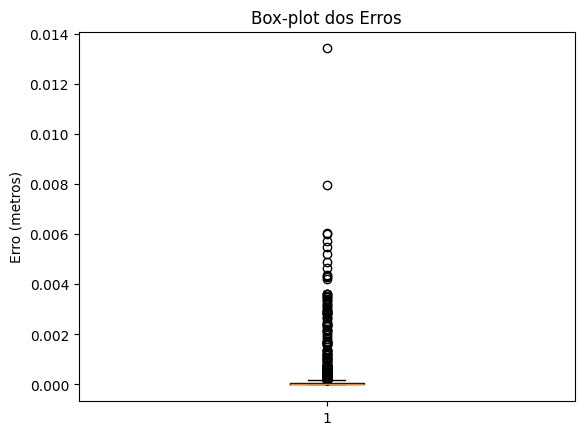

In [182]:
plt.boxplot(errors)
plt.ylabel('Erro (metros)')
plt.title('Box-plot dos Erros')
plt.show()